### Data Preparation and Machine Learning Algorithms

Here, we will choose the features which we will use in the dataset to create a binary classifier to determine if the network traffic is benign or malicious.

We will try to find the most suitable unsupervised technique among somelike: K means, Isolation forest, Elliptical Envelope, LOF and mean shift. Also, we will see there performance.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import shap
import scikitplot as skplt
import eli5
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool
from eli5.sklearn import PermutationImportance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from scipy.stats import ks_2samp
from scipy.stats import describe
from imblearn.over_sampling import SMOTENC
from collections import Counter
from IPython.display import display
import joblib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 1. Dataset Preparation

In this step we will replace infinte and negative values and we will define the features and the target variables.

In [3]:
df= pd.read_csv('all_data.csv')

In [4]:
def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df

df = replace_infinity_with_mean(df)
df = replace_negative_values_with_mean(df)
df.columns

Index(['Unnamed: 0', 'dst_port', 'protocol', 'timestamp', 'flow_duration',
       'tot_fwd_pkts', 'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts',
       'fwd_pkt_len_max', 'fwd_pkt_len_min', 'fwd_pkt_len_mean',
       'fwd_pkt_len_std', 'bwd_pkt_len_max', 'bwd_pkt_len_min',
       'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_tot', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len',
       'fwd_pkts_s', 'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max',
       'pkt_len_mean', 'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt',
       'syn_flag_cnt', 'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt',
       'urg_flag_cnt', 'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio',
       '

In [5]:
X = df.drop(columns=['label', 'label_code', 'label_is_attack'])
y = df[['label_is_attack', 'label_code', 'label']]

## 2. Feature Engineering

Here, we will remove all features with zero variation because it does not have any influence on the prediction of the target variable.

In [6]:
stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

7    bwd_blk_rate_avg
5      bwd_byts_b_avg
6      bwd_pkts_b_avg
0       bwd_psh_flags
1       bwd_urg_flags
4    fwd_blk_rate_avg
2      fwd_byts_b_avg
3      fwd_pkts_b_avg
dtype: object

In [7]:
X = X.drop(columns=features_no_variance)

We will remove some features which does not have influance on predicting the target variable.

In [8]:
X = X.drop(columns=['timestamp', 'dst_port'])

As we saw when we did the exploratory analysis, there exists some features with high correlation between each others which are redundant and need to be ommited and use one of them only.

Thus, we will do clustering based on the correlation between features and pick one feature from each cluster.

In [9]:
cluster_threshold = 1

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)


cluster_ids = hierarchy.fcluster(corr_linkage, cluster_threshold, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = X.columns[selected_features].tolist()

print('Selected features:')
pd.Series(selected_features)

Selected features:


0            Unnamed: 0
1              protocol
2         flow_duration
3          tot_fwd_pkts
4          tot_bwd_pkts
5       totlen_fwd_pkts
6       totlen_bwd_pkts
7      fwd_pkt_len_mean
8       fwd_pkt_len_std
9      bwd_pkt_len_mean
10          flow_byts_s
11          flow_pkts_s
12         flow_iat_std
13         flow_iat_min
14          fwd_iat_tot
15          fwd_iat_min
16          bwd_iat_tot
17          bwd_iat_min
18        fwd_psh_flags
19        fwd_urg_flags
20           bwd_pkts_s
21         fin_flag_cnt
22         rst_flag_cnt
23         psh_flag_cnt
24         ack_flag_cnt
25         urg_flag_cnt
26        down_up_ratio
27    init_fwd_win_byts
28    init_bwd_win_byts
29     fwd_seg_size_min
30          active_mean
31            idle_mean
dtype: object

In [10]:
X = X[selected_features]
X=X.drop(columns=['Unnamed: 0'],axis=1)
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 31


In [9]:
X.columns

Index(['dst_port', 'protocol', 'timestamp', 'flow_duration', 'tot_fwd_pkts',
       'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts',
       'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'bwd_pkt_len_mean',
       'flow_byts_s', 'flow_pkts_s', 'flow_iat_std', 'flow_iat_min',
       'fwd_iat_tot', 'fwd_iat_min', 'bwd_iat_tot', 'bwd_iat_min',
       'fwd_psh_flags', 'fwd_urg_flags', 'bwd_pkts_s', 'fin_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'down_up_ratio', 'init_fwd_win_byts', 'init_bwd_win_byts',
       'fwd_seg_size_min', 'active_mean', 'idle_mean'],
      dtype='object')

The following figure shows the correlation heatmap after the removal of highly correlated features.

<AxesSubplot:>

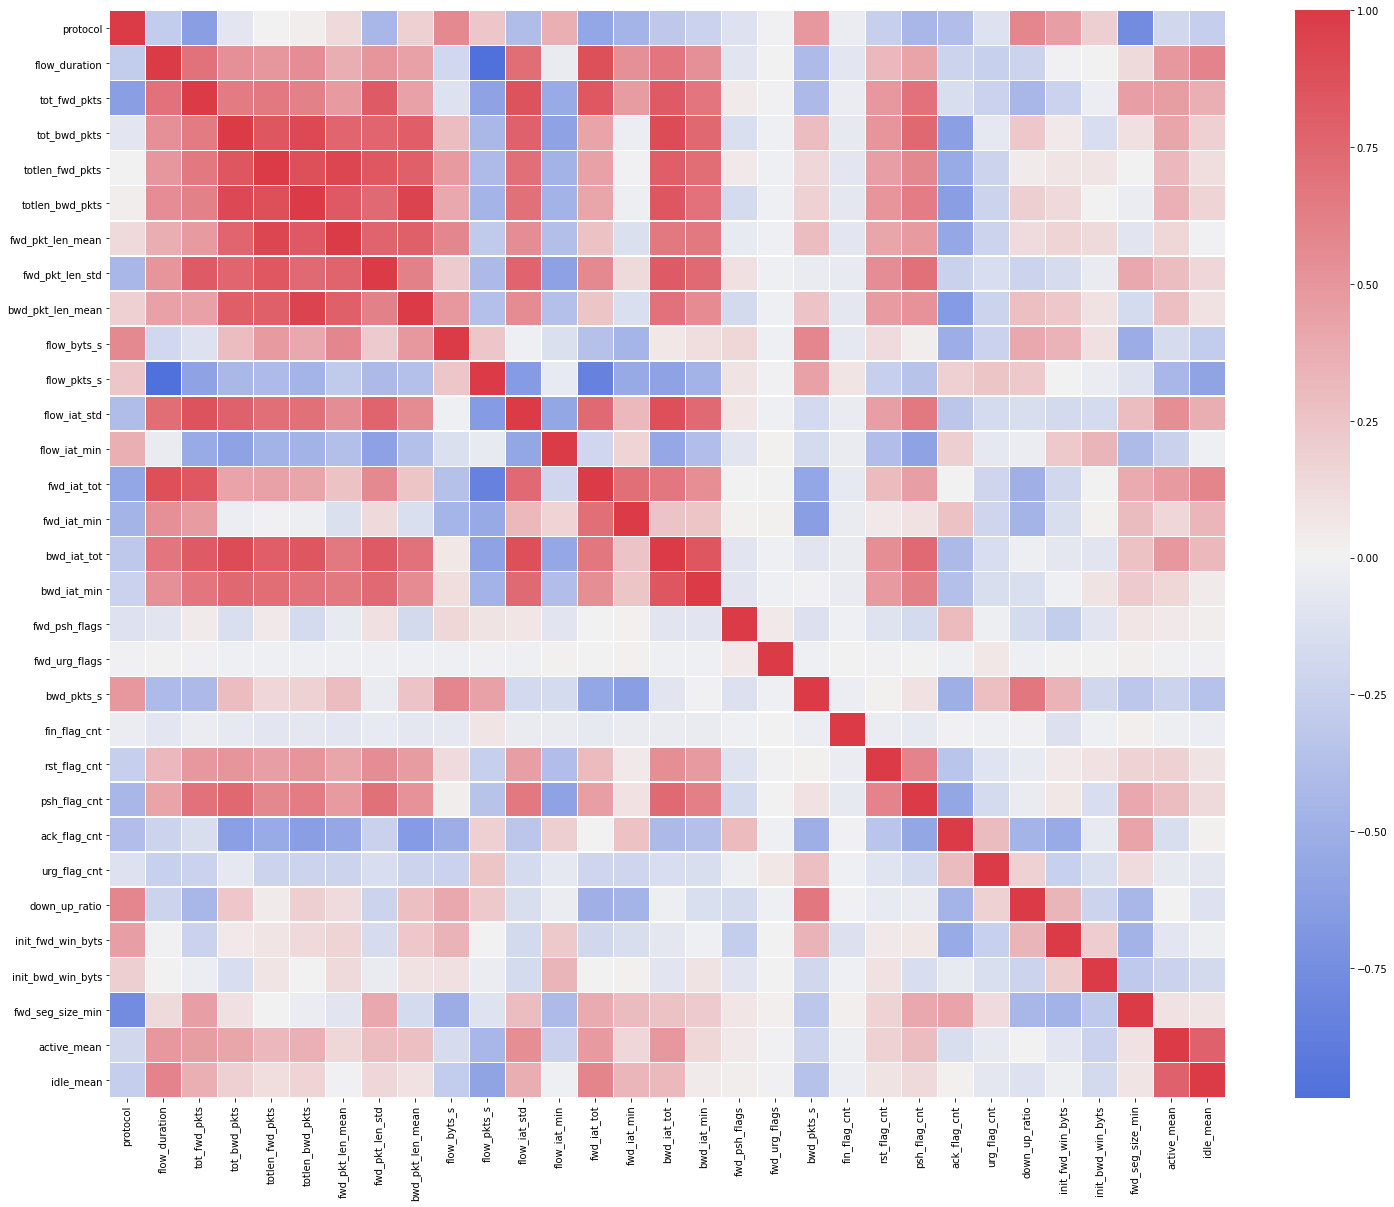

In [60]:
corr_updated = spearmanr(X).correlation
plt.figure(figsize=(25, 20))
sns.heatmap(corr_updated, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

## 3. Model Training Preparation

### 3.1. Train / Test split

In this stage we will split the data into training, evaluation and testing with ratios `0.8/0.1/0.1`.  
In order to insure that all attacks are exists with the same ratio in both the training and testing sets, the split will be stratified by the attack category.

In [5]:
def print_report(ds_type, cls, X_vals, y_true, y_predict, plot_pr=False, plot_roc=False):
    print(f"Classification Report ({ds_type}):")
    print(classification_report(y_true, y_predict))
    print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    
    if plot_roc:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_predict)}")
        skplt.metrics.plot_roc(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    if plot_pr:
        
        skplt.metrics.plot_precision_recall(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    print('\n')

Here, we will also do one-hot-encoded on protocol column.

In [12]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, stratify=y.label_code)
X_eval, X_test, y_eval, y_test = train_test_split(X_hold, y_hold, test_size=0.5, stratify=y_hold.label_code)

X_train_oh = pd.get_dummies(X_train, columns=['protocol'])
X_eval_oh = pd.get_dummies(X_eval, columns=['protocol'])
X_test_oh = pd.get_dummies(X_test, columns=['protocol'])

In [6]:
df = pd.read_pickle('all_data.pkl')
X_train_oh = pd.read_pickle('X_train_oh.pkl')
X_eval_oh = pd.read_pickle('X_eval_oh.pkl')
X_test_oh = pd.read_pickle('X_test_oh.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_eval = pd.read_pickle('y_eval.pkl')
y_test = pd.read_pickle('y_test.pkl')

In [65]:
y.columns

Index(['label_is_attack', 'label_code', 'label'], dtype='object')

Next, we will see the number of benign and different attack types in the original, train, evaluation and test data sets.

In [66]:
y.label.value_counts()

Benign                      13484708
DDOS attack-HOIC              686012
DDoS attacks-LOIC-HTTP        576191
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193360
SSH-Bruteforce                187589
Infilteration                 161934
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye          41508
DoS attacks-Slowloris          10990
DDOS attack-LOIC-UDP            1730
Brute Force -Web                 611
Brute Force -XSS                 230
SQL Injection                     87
Name: label, dtype: int64

In [67]:
y_train.label.value_counts()

Benign                      10787766
DDOS attack-HOIC              548809
DDoS attacks-LOIC-HTTP        460953
DoS attacks-Hulk              369530
Bot                           228953
FTP-BruteForce                154688
SSH-Bruteforce                150071
Infilteration                 129547
DoS attacks-SlowHTTPTest      111912
DoS attacks-GoldenEye          33206
DoS attacks-Slowloris           8792
DDOS attack-LOIC-UDP            1384
Brute Force -Web                 489
Brute Force -XSS                 184
SQL Injection                     70
Name: label, dtype: int64

In [68]:
y_eval.label.value_counts()

Benign                      1348471
DDOS attack-HOIC              68601
DDoS attacks-LOIC-HTTP        57619
DoS attacks-Hulk              46191
Bot                           28619
FTP-BruteForce                19336
SSH-Bruteforce                18759
Infilteration                 16193
DoS attacks-SlowHTTPTest      13989
DoS attacks-GoldenEye          4151
DoS attacks-Slowloris          1099
DDOS attack-LOIC-UDP            173
Brute Force -Web                 61
Brute Force -XSS                 23
SQL Injection                     9
Name: label, dtype: int64

In [69]:
y_test.label.value_counts()

Benign                      1348471
DDOS attack-HOIC              68602
DDoS attacks-LOIC-HTTP        57619
DoS attacks-Hulk              46191
Bot                           28619
FTP-BruteForce                19336
SSH-Bruteforce                18759
Infilteration                 16194
DoS attacks-SlowHTTPTest      13989
DoS attacks-GoldenEye          4151
DoS attacks-Slowloris          1099
DDOS attack-LOIC-UDP            173
Brute Force -Web                 61
Brute Force -XSS                 23
SQL Injection                     8
Name: label, dtype: int64

### 3.2 Metrics for Evaluation

In [18]:
percentage_benign = len(y_train.label_is_attack[y_train.label_is_attack == 0]) / len(y_train.label_is_attack)

print('Class occurences:')
print(y_train.label_is_attack.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
0    10787766
1     2198588
Name: label_is_attack, dtype: int64
Percentage of benign samples: 0.8307


As we see that the data is highly embalanced since we have arround `~83%` `Benign` records. Thus, the metric `accuracy` is not suitable to measure the performance of a classifier based on this dataset since the `accuracy` of a dummy classifier as we will see is `0.83`. Therefore, we will use the following metric to evaluate the performance of the classifiers:

* `Recall (weighted avg)` which is more important since the goal is to detect as many attacks as possible. So, the classifier with higher recall will be better.
* `Precision (weighted avg)` which should be large to reduce the number of false-positives(when we said that a netwirk flow is attack but it is not).


## 4 Classifiers

Unsupervised Classifiers

### 4.1 K means

Here, we will perform k mean clustering to group the similar network flows together.

In [7]:
from sklearn.cluster import KMeans                      #
from mpl_toolkits.mplot3d import Axes3D                 #
import io                                               #
import pickle                                           #
import requests                                         #
from sklearn.decomposition import PCA                   #
from sklearn import preprocessing  
from matplotlib import colors as mcolors                #
from sklearn.cluster import AgglomerativeClustering     #
from sklearn.neighbors import LocalOutlierFactor        #
############IMPORTS######################################
import warnings
warnings.filterwarnings('ignore')

In [88]:
features = list(X)
for i in range(len(features)):
    X[features[i]] =  pd.to_numeric(X[features[i]], errors='coerce')

In [89]:
# Creating a new normalized dataframe
X2 = X[features].dropna()
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(X2)
X2 = pd.DataFrame(np_scaled)

In [90]:
# Principle Component Analasys Step
pca = PCA(n_components=2)
X2 = pca.fit_transform(X2)
np_scaled = min_max_scaler.fit_transform(X2)
X2 = pd.DataFrame(np_scaled)

In [26]:
#Initialize the class object
kmeans2 = KMeans(n_clusters= 2)
 
#predict the labels of clusters.
label = kmeans2.fit_predict(X2)
#df1['New_clus']= label
print(label)

[0 0 0 ... 0 0 0]


In [30]:
l=y.label_is_attack

Here, we will plot in the first graph the data points after K-means clustering and the other one is for the data points before clustering

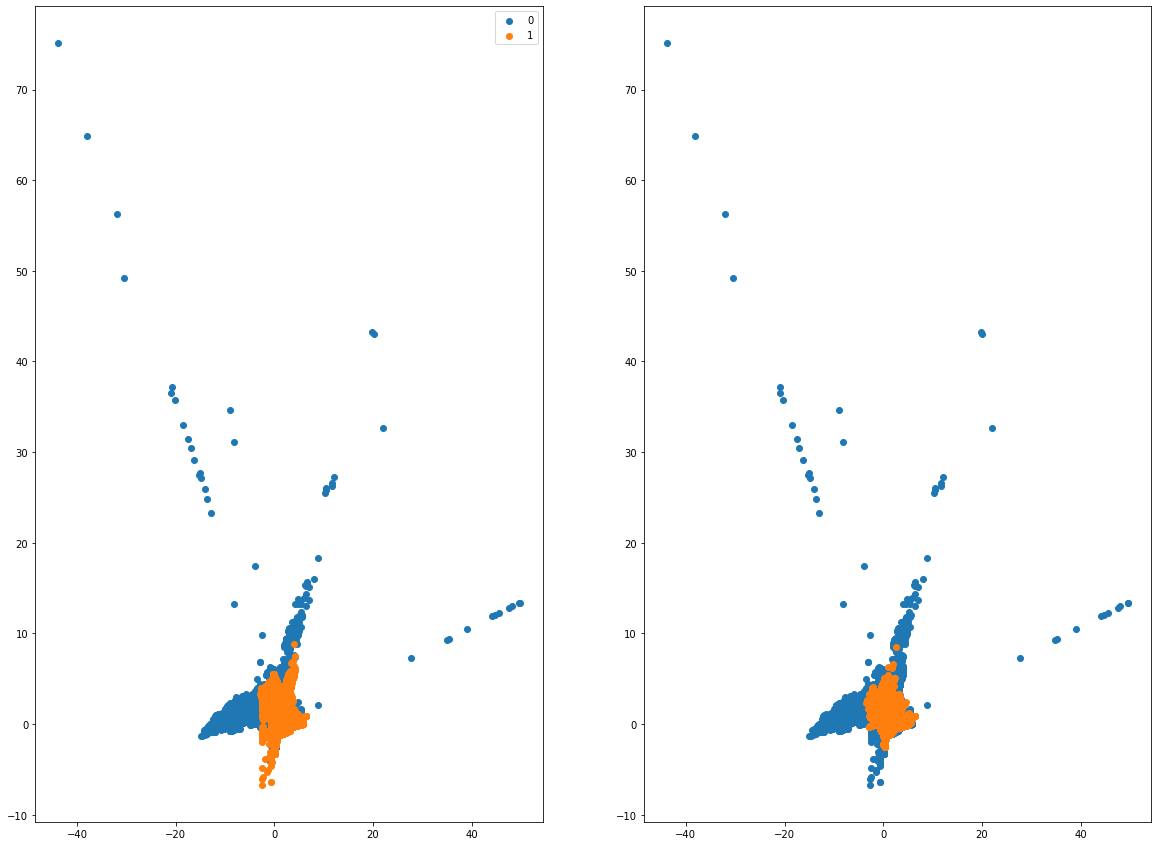

In [75]:
relabels = np.choose(label,[1,0]).astype(np.int64)
u_label = np.unique(label)
y_label = np.unique(l) 
#plotting the results:
plt.figure(figsize=(20,15))
for i,j in zip(u_label,y_label):

    plt.subplot(1,2,2)
    plt.scatter(X2[l== j].iloc[:,0] , X2[l== j].iloc[:,1],label = j)
    plt.subplot(1,2,1)
    plt.scatter(X2[relabels == i].iloc[:,0] , X2[relabels == i].iloc[:,1] , label = i)

    #plt.scatter(centroid[:,0] , centroid[:,1] , s = 80, color = 'k')
    plt.legend()
plt.show()

We will see the accuracy of the model 

In [76]:
print(classification_report(l,relabels))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81  13484708
           1       0.31      0.56      0.40   2748235

    accuracy                           0.71  16232943
   macro avg       0.60      0.65      0.60  16232943
weighted avg       0.79      0.71      0.74  16232943



In [212]:
cm5=confusion_matrix(l, relabels)
print(" Accuracy Score for Kmeans :",accuracy_score(l, relabels))
print(" Precision for Kmeans :", precision_score(l, relabels))
print(" Recall for Kmeans :", recall_score(l, relabels))
print(" Confusion Matrix: \n", cm5)

 Accuracy Score for Kmeans : 0.7115772537364297
 Precision for Kmeans : 0.3075735831039433
 Recall for Kmeans : 0.562332187749592
 Confusion Matrix: 
 [[10005572  3479136]
 [ 1202814  1545421]]


### Meanshift

In [47]:
from sklearn.cluster import MeanShift,estimate_bandwidth

In [ ]:
X=df.drop(['label_is_attack','label','label_code'],axis=1)
X=pd.get_dummies(X, columns=['protocol'])
tr=df.label_is_attack
X3=X.copy()
features = list(X3)
for i in range(len(features)):
    X3[features[i]] =  pd.to_numeric(X3[features[i]], errors='coerce')

# Creating a new normalized dataframe
X3 = X3[features].dropna()
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(X3)
X3 = pd.DataFrame(np_scaled)

# Principle Component Analasys Step
pca = PCA(n_components=2)
X3 = pca.fit_transform(X3)
np_scaled = min_max_scaler.fit_transform(X3)
X3 = pd.DataFrame(np_scaled)
#bandwith = estimate_bandwidth(X3)
ms = MeanShift(bandwidth=1.1985, bin_seeding=True,n_jobs=4)
ms.fit_predict(X3)

# The following bandwidth can be automatically detected using
ms_labels_pca = ms.labels_
ms_pca_cluster_centers = ms.cluster_centers_

ms_pca_labels_unique = np.unique(ms_labels_pca)
ms_pca_n_clusters_ = len(ms_pca_labels_unique)

In [96]:
print("number of estimated clusters : %d" % ms_pca_n_clusters_)

number of estimated clusters : 44


In [97]:
# how many observations in each cluster
cluster, count = np.unique(ms_labels_pca, return_counts=True)
dict(zip(cluster, count))

{0: 8804512,
 1: 5421879,
 2: 973181,
 3: 419780,
 4: 609184,
 5: 580,
 6: 250,
 7: 2828,
 8: 81,
 9: 71,
 10: 45,
 11: 44,
 12: 33,
 13: 32,
 14: 20,
 15: 16,
 16: 16,
 17: 6,
 18: 4,
 19: 3,
 20: 3,
 21: 3,
 22: 2,
 23: 2,
 24: 2,
 25: 1,
 26: 2,
 27: 74,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 2,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 273}

<Figure size 432x288 with 0 Axes>

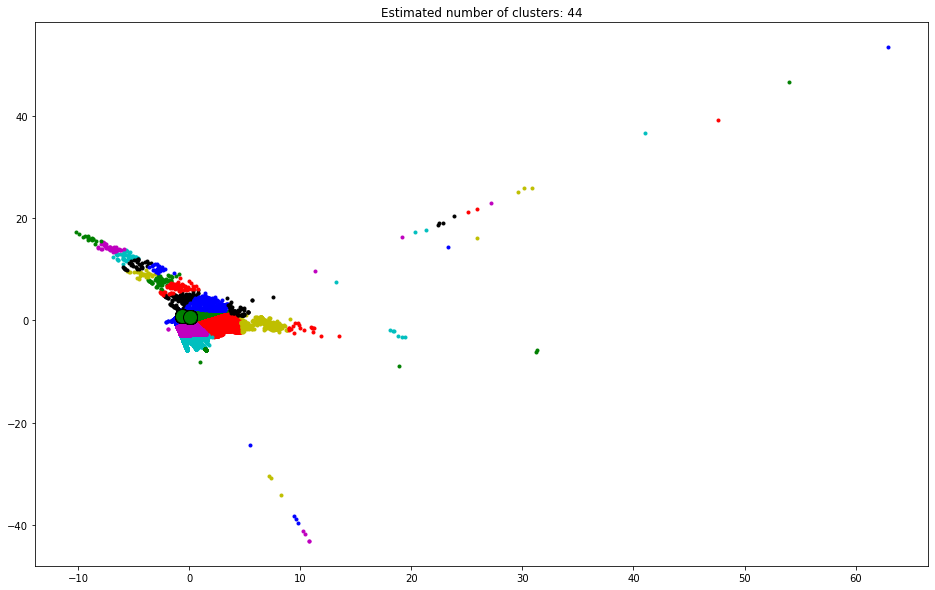

In [98]:
from itertools import cycle
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(16,10))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(ms_pca_n_clusters_), colors):
    my_members = ms_labels_pca == k
    cluster_center = ms_pca_cluster_centers[k]
    plt.plot(X3.iloc[my_members, 0], X3.iloc[my_members, 1], col + '.')
    plt.plot(ms_pca_cluster_centers[0], ms_pca_cluster_centers[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % len(cluster))
plt.show()

In [99]:
# consolidate outlier 
def consolodate_outliers(labels, threshold): 
    new_labels = []
    for i in labels: 
        if i == threshold: 
            new_labels.append(0)
        else: 
            new_labels.append(1)

    count = np.unique(new_labels, return_counts=True)
    return new_labels,pd.DataFrame(count)

pca_label, count = consolodate_outliers(ms_labels_pca, 0)
count

,0,1
0,0,1
1,8804512,7428431


In [100]:
print(classification_report(tr,pca_label))

              precision    recall  f1-score   support

           0       0.83      0.54      0.66  13484708
           1       0.17      0.46      0.25   2748235

    accuracy                           0.53  16232943
   macro avg       0.50      0.50      0.45  16232943
weighted avg       0.72      0.53      0.59  16232943



In [125]:
meanshift_data=X.copy()
meanshift_data['pred'] = pca_label

### 4.2 Isolation Forest

In [8]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
%matplotlib inline

In [79]:
model = IsolationForest(n_estimators=100,n_jobs=4,random_state=2021, max_samples='auto', contamination=.16)

# Applied on trained data (80% of all data)

In [80]:
y_pred_train1=model.fit(X_train_oh)

In [81]:
dataset_test1 = X_test_oh.copy()
y_pred1=model.predict(X_test_oh)
dataset_test1['if_scores']=model.decision_function(X_test_oh)
dataset_test1.head(2)

,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_mean,fwd_pkt_len_std,bwd_pkt_len_mean,flow_byts_s,flow_pkts_s,...,down_up_ratio,init_fwd_win_byts,init_bwd_win_byts,fwd_seg_size_min,active_mean,idle_mean,protocol_0,protocol_6,protocol_17,if_scores
7945668,940.0,1,1,77,155,77.0,0.0,155.0,246808.510638,2127.659574,...,1,12088.350041,17682.268468,8,0.0,0.0,0,0,1,0.049665
14495017,4308.0,2,0,0,0,0.0,0.0,0.0,0.000000,464.252553,...,0,225.000000,17682.268468,32,0.0,0.0,0,1,0,0.101550


In [83]:
dataset_test1['is_attack'] = y_test.label_is_attack
dataset_test1['if_anomaly']=list(y_pred1)
dataset_test1.loc[dataset_test1['is_attack'] ==1, 'normal'] = -1
dataset_test1.loc[dataset_test1['is_attack'] ==0, 'normal'] = 1
dataset_test1.head(2)

,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_mean,fwd_pkt_len_std,bwd_pkt_len_mean,flow_byts_s,flow_pkts_s,...,fwd_seg_size_min,active_mean,idle_mean,protocol_0,protocol_6,protocol_17,if_scores,is_attack,if_anomaly,normal
7945668,940.0,1,1,77,155,77.0,0.0,155.0,246808.510638,2127.659574,...,8,0.0,0.0,0,0,1,0.049665,0,1,1.0
14495017,4308.0,2,0,0,0,0.0,0.0,0.0,0.000000,464.252553,...,32,0.0,0.0,0,1,0,0.101550,1,1,-1.0


In [84]:
print(classification_report(dataset_test1['normal'],dataset_test1['if_anomaly']))

              precision    recall  f1-score   support

        -1.0       0.05      0.05      0.05    274824
         1.0       0.81      0.82      0.81   1348471

    accuracy                           0.69   1623295
   macro avg       0.43      0.43      0.43   1623295
weighted avg       0.68      0.69      0.68   1623295



In [103]:
predicted_anomaly_index1=dataset_test1.loc[dataset_test1['if_anomaly']==-1]
predicted_anomaly_index1=list(predicted_anomaly_index1.index)
original_anomaly_index1=dataset_test1.loc[dataset_test1['normal']==-1]
original_anomaly_index1=list(original_anomaly_index1.index)

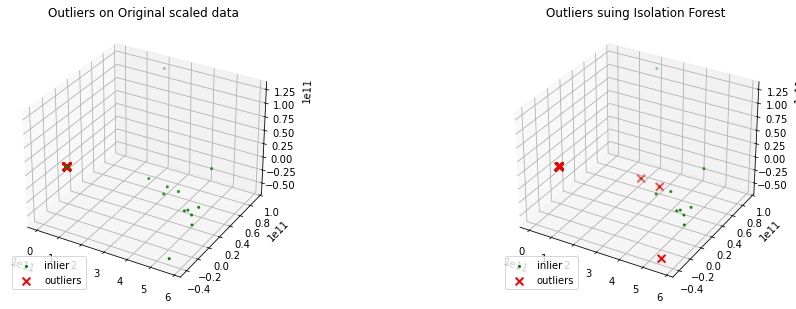

In [104]:
fig=plt.figure(figsize=(25, 5))
ax= fig.add_subplot(131, projection='3d')
ax.scatter(X_reduced[:,0],X_reduced[:,1], zs=X_reduced[:,2], s=4, lw=1, label='inlier', c="green", marker="o")
ax.scatter(X_reduced[original_anomaly_index1,0],X_reduced[original_anomaly_index1,1], zs=X_reduced[original_anomaly_index1,2], lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend(loc='lower left')
plt.title('Outliers on Original scaled data')
ax= fig.add_subplot(132, projection='3d')
plt.title('Outliers suing Isolation Forest')
ax.scatter(X_reduced[:,0],X_reduced[:,1], zs=X_reduced[:,2], s=4, lw=1, label='inlier', c="green", marker="o")
ax.scatter(X_reduced[predicted_anomaly_index1,0],X_reduced[predicted_anomaly_index1,1], zs=X_reduced[predicted_anomaly_index1,2], lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend(loc='lower left')
plt.show()

### 4.4 LOF (Local Outlier Factor) detection

In [70]:
df.columns

Index(['protocol', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts',
       'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_mean',
       'fwd_pkt_len_std', 'bwd_pkt_len_mean', 'flow_byts_s', 'flow_pkts_s',
       'flow_iat_std', 'flow_iat_min', 'fwd_iat_tot', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_min', 'fwd_psh_flags', 'fwd_urg_flags',
       'bwd_pkts_s', 'fin_flag_cnt', 'rst_flag_cnt', 'psh_flag_cnt',
       'ack_flag_cnt', 'urg_flag_cnt', 'down_up_ratio', 'init_fwd_win_byts',
       'init_bwd_win_byts', 'fwd_seg_size_min', 'active_mean', 'idle_mean',
       'label_is_attack', 'label_code', 'label'],
      dtype='object')

In [71]:
X = df.drop(['label_is_attack','label_code','label'],axis = 1)
y = df.label_is_attack

In [72]:
X1=X.copy()
features = list(X1)

In [73]:
for i in range(len(features)):
    X1[features[i]] =  pd.to_numeric(X1[features[i]], errors='coerce')

# Creating a new normalized dataframe
X1 = X1[features].dropna()
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(X1)
X1 = pd.DataFrame(np_scaled)

# Principle Component Analasys Step
pca = PCA(n_components=2)
X1 = pca.fit_transform(X1)
np_scaled = min_max_scaler.fit_transform(X1)
X1 = pd.DataFrame(np_scaled)

In [74]:
from sklearn.neighbors import LocalOutlierFactor 
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred1 = clf.fit_predict(X1)

In [75]:
y_true=y

In [76]:
y_true=y_true.replace(to_replace=1,value=-1)
y_true=y_true.replace(to_replace=0,value=1)
y_true

0           1
1           1
2           1
3           1
4           1
           ..
16232938   -1
16232939   -1
16232940    1
16232941   -1
16232942   -1
Name: label_is_attack, Length: 16232943, dtype: int64

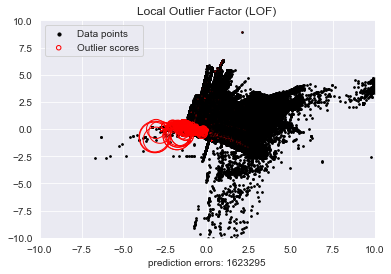

In [155]:
ground_truth = np.ones(len(X1), dtype=int)
n_errors = (y_pred1 != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X1[0], X1[1], 
            color='k', s=3., label='Data points')

# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X1[0], X1[1],
            s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [77]:
print(classification_report(y_true,y_pred1))

              precision    recall  f1-score   support

          -1       0.09      0.05      0.07   2748235
           1       0.82      0.89      0.86  13484708

    accuracy                           0.75  16232943
   macro avg       0.46      0.47      0.46  16232943
weighted avg       0.70      0.75      0.72  16232943



In [67]:
joblib.dump(clf, 'LOF.pkl')

In [66]:
model_LOF = joblib.load('LOF.pkl')

In [ ]:
model_LOF.fit_predict

## Combined Models

### Kmeans with logistic regression and random forest

In [283]:
X_train_oh=X_train_oh.drop(['km_clust'],axis=1)
X_test_oh = X_test_oh.drop(['km_clust'],axis=1)

In [268]:
import threading
threading.activeCount()

8

In [5]:
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [270]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [294]:
class clust():
    def _load_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = X_train_oh, X_test_oh,y_train.label_is_attack,y_test.label_is_attack 
    def __init__(self):
        self._load_data()
    @timeit
    def classify(self, model=RandomForestClassifier(verbose=1, n_jobs=32, class_weight='balanced')):
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print('Accuracy: {}'.format(accuracy_score(self.y_test, y_pred))) 
        print('F1 Score: {}'.format(f1_score(self.y_test, y_pred)))
     
    @timeit
    def classifylog(self, model=LogisticRegression(solver='saga', n_jobs=32, verbose=2)):
        scaler = StandardScaler()
        scaler.fit(self.X_train)
        model.fit(scaler.transform(self.X_train), self.y_train)
        y_pred = model.predict(self.X_test)
        print('Accuracy: {}'.format(accuracy_score(self.y_test, y_pred)))
        print('F1 Score: {}'.format(f1_score(self.y_test, y_pred)))
        print('Precision Score: {}'.format(precision_score(self.y_test, y_pred)))
        print('Recall Score: {}'.format(recall_score(self.y_test, y_pred)))
        
    @timeit
    def Kmeans(self,output='add'):
        n_clusters = len(np.unique(self.y_train))
        clf = KMeans(n_clusters = n_clusters, random_state=42)
        clf.fit(self.X_train)
        y_labels_train = clf.labels_
        y_labels_test = clf.predict(self.X_test)
        if output == 'add':
            self.X_train['km_clust'] = y_labels_train
            self.X_test['km_clust'] = y_labels_test
        elif output == 'replace':
            self.X_train = y_labels_train[:, np.newaxis]
            print(self.X_train)
            print(self.X_train.shape)
            self.X_test = y_labels_test[:, np.newaxis]
        else:
            raise ValueError('output should be either add or replace')
        return self

In [290]:
clust().X_train.shape

(12986354, 34)

#### Kmeans with logistic regression

In [9]:
features = list(X_train_oh)
for i in range(len(features)):
    X_train_oh[features[i]] =  pd.to_numeric(X_train_oh[features[i]], errors='coerce')
# Creating a new normalized dataframe
X2 = X_train_oh[features].dropna()
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(X2)
X2 = pd.DataFrame(np_scaled)
# Principle Component Analasys Step
pca = PCA(n_components=2)
X2 = pca.fit_transform(X2)
np_scaled = min_max_scaler.fit_transform(X2)
X2 = pd.DataFrame(np_scaled)
#Initialize the class object
kmeans2 = KMeans(n_clusters= 2)
 
#predict the labels of clusters.
label = kmeans2.fit_predict(X2)


In [10]:
features = list(X_test_oh)
for i in range(len(features)):
    X_test_oh[features[i]] =  pd.to_numeric(X_test_oh[features[i]], errors='coerce')
# Creating a new normalized dataframe
X3 = X_test_oh[features].dropna()
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(X3)
X3 = pd.DataFrame(np_scaled)
# Principle Component Analasys Step
pca = PCA(n_components=2)
X3 = pca.fit_transform(X3)
np_scaled = min_max_scaler.fit_transform(X3)
X3 = pd.DataFrame(np_scaled)
#Initialize the class object
kmeans3 = KMeans(n_clusters= 2)
 
#predict the labels of clusters.
label1 = kmeans3.fit_predict(X3)


In [11]:
train_log = X_train_oh.copy()
train_log['clus'] = label
test_log = X_test_oh.copy()
test_log['clus'] = label1

In [10]:
scaler = StandardScaler()
scaler.fit(train_log)

StandardScaler()

In [11]:
cls_lr = LogisticRegression(solver='saga', n_jobs=32, verbose=2)
cls_lr.fit(scaler.transform(train_log), y_train.label_is_attack)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


max_iter reached after 2772 seconds


[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed: 46.2min finished


LogisticRegression(n_jobs=32, solver='saga', verbose=2)

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.91      0.96      0.94   1348471
           1       0.74      0.55      0.63    274824

    accuracy                           0.89   1623295
   macro avg       0.82      0.76      0.78   1623295
weighted avg       0.88      0.89      0.88   1623295

Avg Precision Score: 0.4829066730293959


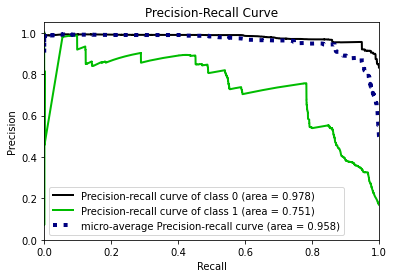

In [12]:
print_report('Test', cls_lr, scaler.transform(test_log), y_test.label_is_attack, cls_lr.predict(scaler.transform(test_log)), plot_pr=True)

Kmeans with random forest

In [12]:
model = RandomForestClassifier(verbose=1, n_jobs=32, class_weight='balanced')
model.fit(train_log,  y_train.label_is_attack)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed: 15.7min finished


RandomForestClassifier(class_weight='balanced', n_jobs=32, verbose=1)

In [13]:
y_pred = model.predict(test_log)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    5.2s finished


In [14]:
print_report('Test', model, test_log, y_test.label_is_attack, y_pred)

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.97      0.95      0.96    274824

    accuracy                           0.99   1623295
   macro avg       0.98      0.97      0.98   1623295
weighted avg       0.99      0.99      0.99   1623295

Avg Precision Score: 0.931931821900797




In [292]:
result1 = clust().Kmeans().classify()
result1 

'Kmeans'  143570.92 ms


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed: 15.9min finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    7.0s finished


Accuracy: 0.9856415500571368
F1 Score: 0.9574353074380468
'classify'  979023.72 ms


### LOF and Random Forest

LOF on training dataset

In [138]:
X=X_train_oh.copy()

In [139]:
X_train_LOF = X.copy()
features = list(X_train_LOF)
for i in range(len(features)):
    X_train_LOF[features[i]] =  pd.to_numeric(X_train_LOF[features[i]], errors='coerce')

# Creating a new normalized dataframe
X_train_LOF = X_train_LOF[features].dropna()
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(X_train_LOF)
X_train_LOF = pd.DataFrame(np_scaled)

# Principle Component Analasys Step
pca = PCA(n_components=2)
X_train_LOF = pca.fit_transform(X_train_LOF)
np_scaled = min_max_scaler.fit_transform(X_train_LOF)
X_train_LOF = pd.DataFrame(np_scaled)

In [140]:
X1=X_test_oh.copy()

In [141]:
X1=X_test_oh.copy()
X_test_LOF = X1.copy()
features = list(X_test_LOF)
for i in range(len(features)):
    X_test_LOF[features[i]] =  pd.to_numeric(X_test_LOF[features[i]], errors='coerce')

# Creating a new normalized dataframe
X_test_LOF = X_test_LOF[features].dropna()
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(X_test_LOF)
X_test_LOF = pd.DataFrame(np_scaled)

# Principle Component Analasys Step
pca = PCA(n_components=2)
X_test_LOF = pca.fit_transform(X_test_LOF)
np_scaled = min_max_scaler.fit_transform(X_test_LOF)
X_test_LOF = pd.DataFrame(np_scaled)

In [142]:
LOF = LocalOutlierFactor(n_neighbors=20, novelty=False, contamination=0.16,n_jobs=32)

In [143]:
y_labels_test = LOF.fit_predict(X_test_LOF)

In [144]:
X1['is_attack'] = y_test.label_is_attack
X1['if_anomaly']=list(y_labels_test)
X1.loc[X1['is_attack'] ==1, 'normal'] = -1
X1.loc[X1['is_attack'] ==0, 'normal'] = 1
X1.head(2)

,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_mean,fwd_pkt_len_std,bwd_pkt_len_mean,flow_byts_s,flow_pkts_s,...,init_bwd_win_byts,fwd_seg_size_min,active_mean,idle_mean,protocol_0,protocol_6,protocol_17,is_attack,if_anomaly,normal
7945668,940.0,1,1,77,155,77.0,0.0,155.0,246808.510638,2127.659574,...,17682.268468,8,0.0,0.0,0,0,1,0,1,1.0
14495017,4308.0,2,0,0,0,0.0,0.0,0.0,0.000000,464.252553,...,17682.268468,32,0.0,0.0,0,1,0,1,1,-1.0


In [145]:
print(" Accuracy Score for LOF :",accuracy_score(X1['normal'], X1['if_anomaly']))
print(" Accuracy Score for LOF :",f1_score(X1['normal'], X1['if_anomaly']))
print(" Precision for LOF :", precision_score(X1['normal'], X1['if_anomaly']))
print(" Recall for LOF :", recall_score(X1['normal'], X1['if_anomaly']))

 Accuracy Score for LOF : 0.6998746376967834
 Accuracy Score for LOF : 0.8203594492407554
 Precision for LOF : 0.8158183646274807
 Recall for LOF : 0.8249513708489096


In [146]:
LOF1 = LocalOutlierFactor(n_neighbors=20, novelty=False, contamination=0.16,n_jobs=32)

In [147]:
out = LOF1.fit_predict(X_train_LOF)

In [148]:
y_labels_train = out

In [149]:
X['is_attack'] = y_train.label_is_attack
X['if_anomaly']=list(y_labels_train)
X.loc[X['is_attack'] ==1, 'normal'] = -1
X.loc[X['is_attack'] ==0, 'normal'] = 1
X.head(2)

,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_mean,fwd_pkt_len_std,bwd_pkt_len_mean,flow_byts_s,flow_pkts_s,...,init_bwd_win_byts,fwd_seg_size_min,active_mean,idle_mean,protocol_0,protocol_6,protocol_17,is_attack,if_anomaly,normal
6676218,3133459.0,9,11,1278,1736,142.0,213.26744,157.81818,961.876316,6.382723,...,62856.0,20,0.0,0.0,0,1,0,0,1,1.0
15568248,2788351.0,10,7,1148,1581,114.8,210.09247,225.85715,978.714660,6.096793,...,62852.0,20,0.0,0.0,0,1,0,1,1,-1.0


In [150]:
print(" Accuracy Score for LOF :",accuracy_score(X['normal'], X['if_anomaly']))
print(" f1 Score for LOF :",f1_score(X['normal'], X['if_anomaly']))
print(" Precision for LOF :", precision_score(X['normal'], X['if_anomaly']))
print(" Recall for LOF :", recall_score(X['normal'], X['if_anomaly']))

 Accuracy Score for LOF : 0.7034202979527587
 f1 Score for LOF : 0.8224817841085645
 Precision for LOF : 0.8179288386701168
 Recall for LOF : 0.8270857005982517


#### Random Forest after LOF

In [151]:
X_train_lo = X.drop(['normal','is_attack'],axis=1)
y_train_lo = X['normal']

In [159]:
model2 = RandomForestClassifier(verbose=1, n_jobs=32, class_weight='balanced')
model2.fit(X_train_lo, y_train_lo)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed: 15.5min finished


RandomForestClassifier(class_weight='balanced', n_jobs=32, verbose=1)

In [152]:
X_test_lo = X1.drop(['normal','is_attack'],axis=1)
y_test_lo = X1['normal']

In [160]:
y_pred_rf = model2.predict(X_test_lo)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    6.4s finished


In [161]:
print_report('Test', model2, X_test_lo, y_test_lo, y_pred_rf)

Classification Report (Test):
              precision    recall  f1-score   support

        -1.0       0.96      0.95      0.96    274824
         1.0       0.99      0.99      0.99   1348471

    accuracy                           0.99   1623295
   macro avg       0.98      0.97      0.97   1623295
weighted avg       0.99      0.99      0.99   1623295

Avg Precision Score: 0.9884479499621105




In [166]:
joblib.dump(model2, 'randomforest_lof.pkl')

['randomforest_lof.pkl']

### LOF with logistic regression

In [153]:
scaler = StandardScaler()
scaler.fit(X_train_lo)

StandardScaler()

In [5]:
cls_lr = LogisticRegression(solver='saga', n_jobs=32, verbose=2)
cls_lr.fit(scaler.transform(X_train_lo), y_train_lo)

Classification Report (Test):
              precision    recall  f1-score   support

        -1.0       0.84      0.70      0.76    274824
         1.0       0.94      0.97      0.96   1348471

    accuracy                           0.93   1623295
   macro avg       0.89      0.84      0.86   1623295
weighted avg       0.92      0.93      0.92   1623295

Avg Precision Score: 0.9376187749627509


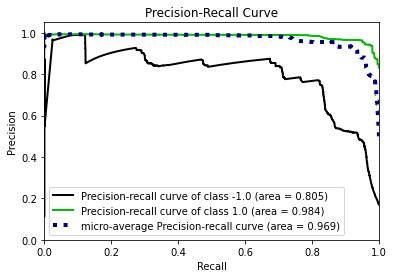

In [156]:
print_report('Test', cls_lr, scaler.transform(X_test_lo), y_test_lo, cls_lr.predict(scaler.transform(X_test_lo)), plot_pr=True)

In [169]:
log_pred=cls_lr.predict(scaler.transform(X_test_lo))

In [158]:
joblib.dump(cls_lr, 'logistic_lof.pkl')

['logistic_lof.pkl']

### LOF with Gradiant Boost

In [63]:
y_train_loo=X['is_attack']

In [67]:
len(y_train_lo[y_train_lo == 1]) / len(y_train_lo[y_train_lo == -1])

4.90667919592029

In [162]:
train_pool = Pool(X_train_lo, y_train_lo)
test_pool = Pool(X_test_lo)

In [163]:
minority_class_weight = len(y_train_lo[y_train_lo == 1]) / len(y_train_lo[y_train_lo == -1])
    
cls_cb = CatBoostClassifier(loss_function='Logloss',
                            eval_metric='Recall',                        
                            class_weights=[1, minority_class_weight],
                            task_type='CPU',
                            verbose=True)

cls_cb.fit(train_pool)

Learning rate set to 0.5
0:	learn: 0.9976096	total: 1.78s	remaining: 29m 40s
1:	learn: 0.9978739	total: 2.73s	remaining: 22m 39s
2:	learn: 0.9986659	total: 3.63s	remaining: 20m 4s
3:	learn: 0.9987825	total: 4.49s	remaining: 18m 38s
4:	learn: 0.9994116	total: 5.43s	remaining: 17m 59s
5:	learn: 0.9994646	total: 6.4s	remaining: 17m 39s
6:	learn: 0.9995296	total: 7.24s	remaining: 17m 6s
7:	learn: 0.9996400	total: 8.09s	remaining: 16m 43s
8:	learn: 0.9996392	total: 9.01s	remaining: 16m 32s
9:	learn: 0.9997452	total: 9.9s	remaining: 16m 20s
10:	learn: 0.9997516	total: 10.8s	remaining: 16m 9s
11:	learn: 0.9998261	total: 11.7s	remaining: 16m
12:	learn: 0.9998270	total: 12.5s	remaining: 15m 52s
13:	learn: 0.9998612	total: 13.5s	remaining: 15m 50s
14:	learn: 0.9998563	total: 14.4s	remaining: 15m 42s
15:	learn: 0.9998532	total: 15.2s	remaining: 15m 37s
16:	learn: 0.9998509	total: 16.1s	remaining: 15m 31s
17:	learn: 0.9999077	total: 16.9s	remaining: 15m 24s
18:	learn: 0.9999080	total: 17.9s	remain

154:	learn: 0.9999319	total: 2m 2s	remaining: 11m 9s
155:	learn: 0.9999319	total: 2m 3s	remaining: 11m 8s
156:	learn: 0.9999319	total: 2m 4s	remaining: 11m 8s
157:	learn: 0.9999319	total: 2m 5s	remaining: 11m 7s
158:	learn: 0.9999319	total: 2m 5s	remaining: 11m 6s
159:	learn: 0.9999319	total: 2m 6s	remaining: 11m 5s
160:	learn: 0.9999319	total: 2m 7s	remaining: 11m 4s
161:	learn: 0.9999319	total: 2m 8s	remaining: 11m 3s
162:	learn: 0.9999319	total: 2m 9s	remaining: 11m 2s
163:	learn: 0.9999319	total: 2m 9s	remaining: 11m 1s
164:	learn: 0.9999319	total: 2m 10s	remaining: 11m 1s
165:	learn: 0.9999319	total: 2m 11s	remaining: 11m
166:	learn: 0.9999319	total: 2m 12s	remaining: 10m 59s
167:	learn: 0.9999319	total: 2m 12s	remaining: 10m 58s
168:	learn: 0.9999319	total: 2m 13s	remaining: 10m 57s
169:	learn: 0.9999319	total: 2m 14s	remaining: 10m 56s
170:	learn: 0.9999319	total: 2m 15s	remaining: 10m 55s
171:	learn: 0.9999319	total: 2m 16s	remaining: 10m 54s
172:	learn: 0.9999319	total: 2m 16s

306:	learn: 0.9999500	total: 3m 58s	remaining: 8m 58s
307:	learn: 0.9999500	total: 3m 59s	remaining: 8m 57s
308:	learn: 0.9999500	total: 3m 59s	remaining: 8m 56s
309:	learn: 0.9999500	total: 4m	remaining: 8m 55s
310:	learn: 0.9999500	total: 4m 1s	remaining: 8m 54s
311:	learn: 0.9999500	total: 4m 2s	remaining: 8m 54s
312:	learn: 0.9999500	total: 4m 3s	remaining: 8m 53s
313:	learn: 0.9999500	total: 4m 3s	remaining: 8m 52s
314:	learn: 0.9999500	total: 4m 4s	remaining: 8m 51s
315:	learn: 0.9999500	total: 4m 5s	remaining: 8m 51s
316:	learn: 0.9999500	total: 4m 6s	remaining: 8m 50s
317:	learn: 0.9999500	total: 4m 6s	remaining: 8m 49s
318:	learn: 0.9999500	total: 4m 7s	remaining: 8m 48s
319:	learn: 0.9999500	total: 4m 8s	remaining: 8m 47s
320:	learn: 0.9999500	total: 4m 9s	remaining: 8m 47s
321:	learn: 0.9999500	total: 4m 9s	remaining: 8m 46s
322:	learn: 0.9999500	total: 4m 10s	remaining: 8m 45s
323:	learn: 0.9999500	total: 4m 11s	remaining: 8m 44s
324:	learn: 0.9999500	total: 4m 12s	remainin

459:	learn: 0.9999500	total: 5m 57s	remaining: 6m 59s
460:	learn: 0.9999500	total: 5m 58s	remaining: 6m 59s
461:	learn: 0.9999500	total: 5m 59s	remaining: 6m 58s
462:	learn: 0.9999500	total: 6m	remaining: 6m 57s
463:	learn: 0.9999500	total: 6m	remaining: 6m 56s
464:	learn: 0.9999500	total: 6m 1s	remaining: 6m 56s
465:	learn: 0.9999500	total: 6m 2s	remaining: 6m 55s
466:	learn: 0.9999500	total: 6m 3s	remaining: 6m 54s
467:	learn: 0.9999500	total: 6m 3s	remaining: 6m 53s
468:	learn: 0.9999500	total: 6m 4s	remaining: 6m 52s
469:	learn: 0.9999500	total: 6m 5s	remaining: 6m 52s
470:	learn: 0.9999500	total: 6m 6s	remaining: 6m 51s
471:	learn: 0.9999500	total: 6m 7s	remaining: 6m 50s
472:	learn: 0.9999500	total: 6m 7s	remaining: 6m 49s
473:	learn: 0.9999500	total: 6m 8s	remaining: 6m 49s
474:	learn: 0.9999500	total: 6m 9s	remaining: 6m 48s
475:	learn: 0.9999500	total: 6m 10s	remaining: 6m 47s
476:	learn: 0.9999500	total: 6m 11s	remaining: 6m 46s
477:	learn: 0.9999500	total: 6m 11s	remaining: 

612:	learn: 0.9999500	total: 7m 57s	remaining: 5m 1s
613:	learn: 0.9999500	total: 7m 58s	remaining: 5m
614:	learn: 0.9999500	total: 7m 58s	remaining: 4m 59s
615:	learn: 0.9999500	total: 7m 59s	remaining: 4m 59s
616:	learn: 0.9999500	total: 8m	remaining: 4m 58s
617:	learn: 0.9999500	total: 8m 1s	remaining: 4m 57s
618:	learn: 0.9999500	total: 8m 2s	remaining: 4m 56s
619:	learn: 0.9999500	total: 8m 2s	remaining: 4m 55s
620:	learn: 0.9999500	total: 8m 3s	remaining: 4m 55s
621:	learn: 0.9999500	total: 8m 4s	remaining: 4m 54s
622:	learn: 0.9999500	total: 8m 5s	remaining: 4m 53s
623:	learn: 0.9999500	total: 8m 6s	remaining: 4m 52s
624:	learn: 0.9999500	total: 8m 6s	remaining: 4m 52s
625:	learn: 0.9999500	total: 8m 7s	remaining: 4m 51s
626:	learn: 0.9999500	total: 8m 8s	remaining: 4m 50s
627:	learn: 0.9999500	total: 8m 9s	remaining: 4m 49s
628:	learn: 0.9999500	total: 8m 9s	remaining: 4m 49s
629:	learn: 0.9999500	total: 8m 10s	remaining: 4m 48s
630:	learn: 0.9999500	total: 8m 11s	remaining: 4m

765:	learn: 0.9999500	total: 9m 57s	remaining: 3m 2s
766:	learn: 0.9999500	total: 9m 57s	remaining: 3m 1s
767:	learn: 0.9999500	total: 9m 58s	remaining: 3m
768:	learn: 0.9999500	total: 9m 59s	remaining: 3m
769:	learn: 0.9999500	total: 10m	remaining: 2m 59s
770:	learn: 0.9999500	total: 10m 1s	remaining: 2m 58s
771:	learn: 0.9999500	total: 10m 1s	remaining: 2m 57s
772:	learn: 0.9999500	total: 10m 2s	remaining: 2m 56s
773:	learn: 0.9999500	total: 10m 3s	remaining: 2m 56s
774:	learn: 0.9999500	total: 10m 4s	remaining: 2m 55s
775:	learn: 0.9999500	total: 10m 5s	remaining: 2m 54s
776:	learn: 0.9999500	total: 10m 5s	remaining: 2m 53s
777:	learn: 0.9999500	total: 10m 6s	remaining: 2m 53s
778:	learn: 0.9999500	total: 10m 7s	remaining: 2m 52s
779:	learn: 0.9999500	total: 10m 8s	remaining: 2m 51s
780:	learn: 0.9999500	total: 10m 8s	remaining: 2m 50s
781:	learn: 0.9999500	total: 10m 9s	remaining: 2m 49s
782:	learn: 0.9999500	total: 10m 10s	remaining: 2m 49s
783:	learn: 0.9999500	total: 10m 11s	rem

916:	learn: 0.9999500	total: 11m 55s	remaining: 1m 4s
917:	learn: 0.9999500	total: 11m 55s	remaining: 1m 3s
918:	learn: 0.9999500	total: 11m 56s	remaining: 1m 3s
919:	learn: 0.9999500	total: 11m 57s	remaining: 1m 2s
920:	learn: 0.9999500	total: 11m 58s	remaining: 1m 1s
921:	learn: 0.9999500	total: 11m 58s	remaining: 1m
922:	learn: 0.9999500	total: 11m 59s	remaining: 1m
923:	learn: 0.9999500	total: 12m	remaining: 59.3s
924:	learn: 0.9999500	total: 12m 1s	remaining: 58.5s
925:	learn: 0.9999500	total: 12m 2s	remaining: 57.7s
926:	learn: 0.9999500	total: 12m 2s	remaining: 56.9s
927:	learn: 0.9999500	total: 12m 3s	remaining: 56.1s
928:	learn: 0.9999500	total: 12m 4s	remaining: 55.4s
929:	learn: 0.9999500	total: 12m 5s	remaining: 54.6s
930:	learn: 0.9999500	total: 12m 5s	remaining: 53.8s
931:	learn: 0.9999500	total: 12m 6s	remaining: 53s
932:	learn: 0.9999500	total: 12m 7s	remaining: 52.2s
933:	learn: 0.9999500	total: 12m 8s	remaining: 51.5s
934:	learn: 0.9999500	total: 12m 9s	remaining: 50.

Classification Report (Test):
              precision    recall  f1-score   support

        -1.0       1.00      0.93      0.97    274824
         1.0       0.99      1.00      0.99   1348471

    accuracy                           0.99   1623295
   macro avg       0.99      0.97      0.98   1623295
weighted avg       0.99      0.99      0.99   1623295

Avg Precision Score: 0.9867949276229038


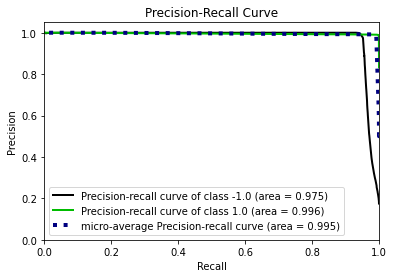

In [165]:
print_report('Test', cls_cb, test_pool, y_test_lo, cls_cb.predict(test_pool), plot_pr=True)

In [170]:
grad_pred=cls_cb.predict(test_pool)

In [167]:
joblib.dump(cls_cb, 'gradiantboost_lof.pkl')

['gradiantboost_lof.pkl']

In [168]:
lof_all = X_test_lo.copy()

In [171]:
lof_all['forest'] = list(y_pred_rf)
lof_all['logistic'] = list(log_pred)
lof_all['gradiant'] = list(grad_pred)
lof_all['is_attack']= y_test_lo

In [173]:
df_pred=lof_all[['forest','logistic','gradiant']]

In [174]:
u=df_pred.mode(axis=1)

In [182]:
u1=df_pred.min(axis=1)

In [185]:
lof_all['mode']=u  

In [188]:
lof_all=lof_all.drop(['max'],axis=1)

In [186]:
print(classification_report(lof_all['is_attack'], lof_all['mode']))

              precision    recall  f1-score   support

        -1.0       1.00      0.93      0.96    274824
         1.0       0.99      1.00      0.99   1348471

    accuracy                           0.99   1623295
   macro avg       0.99      0.97      0.98   1623295
weighted avg       0.99      0.99      0.99   1623295



In [177]:
average_precision_score(lof_all['is_attack'], lof_all['mode'], average='weighted')

0.9863500036574778

### SMOTE oversampling

In [76]:
X_train_s = pd.read_pickle('X_train_smote.pkl')
y_train_s = pd.read_pickle('y_train_smote.pkl')

In [78]:
X_train_s_oh = pd.get_dummies(X_train_s, columns=['protocol'])

In [79]:
X_train_LOF_s = X_train_s_oh.copy()
features = list(X_train_LOF_s)
for i in range(len(features)):
    X_train_LOF_s[features[i]] =  pd.to_numeric(X_train_LOF_s[features[i]], errors='coerce')

# Creating a new normalized dataframe
X_train_LOF_s = X_train_LOF_s[features].dropna()
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(X_train_LOF_s)
X_train_LOF_s = pd.DataFrame(np_scaled)

# Principle Component Analasys Step
pca = PCA(n_components=2)
X_train_LOF_s = pca.fit_transform(X_train_LOF_s)
np_scaled = min_max_scaler.fit_transform(X_train_LOF_s)
X_train_LOF_s = pd.DataFrame(np_scaled)

In [80]:
y_labels_train_s = LOF1.fit_predict(X_train_LOF_s)

In [81]:
X_train_s_oh['is_attack'] = y_train_s
X_train_s_oh['if_anomaly']=list(y_labels_train_s)
X_train_s_oh.loc[X_train_s_oh['is_attack'] ==1, 'normal'] = -1
X_train_s_oh.loc[X_train_s_oh['is_attack'] ==0, 'normal'] = 1
X_train_s_oh.head(2)

,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_mean,fwd_pkt_len_std,bwd_pkt_len_mean,flow_byts_s,flow_pkts_s,...,init_bwd_win_byts,fwd_seg_size_min,active_mean,idle_mean,protocol_0,protocol_6,protocol_17,is_attack,if_anomaly,normal
0,10354.0,3,4,326,129,108.666664,188.216190,32.25,43944.369330,676.067220,...,219.000000,20,0.0,0.0,0,1,0,1,1,-1.0
1,629.0,3,0,77,0,25.666666,23.459185,0.00,122416.534181,4769.475358,...,17682.268468,20,0.0,0.0,0,1,0,0,-1,1.0


### Random forest after LOF (with SMOTE)

In [83]:
X_train_lo_s = X_train_s_oh.drop(['normal','is_attack'],axis=1)
y_train_lo_s = X_train_s_oh['normal']

In [84]:
rf_sm = model2.fit(X_train_lo_s, y_train_lo_s)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed: 18.5min finished


In [85]:
y_pred_rf_s = rf_sm.predict(X_test_lo)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    6.5s finished


In [87]:
print_report('Test', rf_sm, X_test_lo, y_test_lo, y_pred_rf_s)

Classification Report (Test):
              precision    recall  f1-score   support

        -1.0       0.97      0.97      0.97    274824
         1.0       0.99      0.99      0.99   1348471

    accuracy                           0.99   1623295
   macro avg       0.98      0.98      0.98   1623295
weighted avg       0.99      0.99      0.99   1623295

Avg Precision Score: 0.9919616458162177




### Gradiant Boost with LOF (with SMOTE)

In [88]:
train_pool_s = Pool(X_train_lo_s, y_train_lo_s)

In [94]:
minority_class_weight

3.91646792859443

In [89]:
minority_class_weight = len(y_train_lo_s[y_train_lo_s == 1]) / len(y_train_lo_s[y_train_lo_s == -1])
    
cls_cb_s = CatBoostClassifier(loss_function='Logloss',
                            eval_metric='Recall',                        
                            class_weights=[1, minority_class_weight],
                            task_type='CPU',
                            verbose=True)

cls_cb_s.fit(train_pool_s)

Learning rate set to 0.5
0:	learn: 0.9960202	total: 1.66s	remaining: 27m 34s
1:	learn: 0.9956369	total: 2.63s	remaining: 21m 54s
2:	learn: 0.9966122	total: 3.53s	remaining: 19m 32s
3:	learn: 0.9972462	total: 4.55s	remaining: 18m 53s
4:	learn: 0.9979217	total: 5.48s	remaining: 18m 10s
5:	learn: 0.9979628	total: 6.43s	remaining: 17m 45s
6:	learn: 0.9981718	total: 7.38s	remaining: 17m 26s
7:	learn: 0.9981359	total: 8.33s	remaining: 17m 12s
8:	learn: 0.9989715	total: 9.33s	remaining: 17m 7s
9:	learn: 0.9988564	total: 10.3s	remaining: 16m 57s
10:	learn: 0.9988986	total: 11.2s	remaining: 16m 46s
11:	learn: 0.9989222	total: 12.1s	remaining: 16m 35s
12:	learn: 0.9992141	total: 13.1s	remaining: 16m 34s
13:	learn: 0.9992371	total: 14.1s	remaining: 16m 30s
14:	learn: 0.9992905	total: 15s	remaining: 16m 23s
15:	learn: 0.9992910	total: 15.9s	remaining: 16m 20s
16:	learn: 0.9993072	total: 16.9s	remaining: 16m 17s
17:	learn: 0.9992867	total: 17.9s	remaining: 16m 15s
18:	learn: 0.9992425	total: 18.8s	

154:	learn: 0.9997440	total: 2m 18s	remaining: 12m 35s
155:	learn: 0.9997453	total: 2m 19s	remaining: 12m 34s
156:	learn: 0.9997453	total: 2m 20s	remaining: 12m 33s
157:	learn: 0.9997448	total: 2m 21s	remaining: 12m 32s
158:	learn: 0.9997448	total: 2m 22s	remaining: 12m 31s
159:	learn: 0.9997448	total: 2m 22s	remaining: 12m 29s
160:	learn: 0.9997406	total: 2m 23s	remaining: 12m 28s
161:	learn: 0.9997408	total: 2m 24s	remaining: 12m 28s
162:	learn: 0.9997408	total: 2m 25s	remaining: 12m 26s
163:	learn: 0.9997408	total: 2m 26s	remaining: 12m 25s
164:	learn: 0.9997408	total: 2m 27s	remaining: 12m 24s
165:	learn: 0.9997408	total: 2m 27s	remaining: 12m 22s
166:	learn: 0.9997408	total: 2m 28s	remaining: 12m 21s
167:	learn: 0.9997408	total: 2m 29s	remaining: 12m 20s
168:	learn: 0.9997472	total: 2m 30s	remaining: 12m 19s
169:	learn: 0.9997472	total: 2m 31s	remaining: 12m 18s
170:	learn: 0.9997472	total: 2m 32s	remaining: 12m 16s
171:	learn: 0.9997472	total: 2m 32s	remaining: 12m 15s
172:	learn

305:	learn: 0.9997447	total: 4m 25s	remaining: 10m 1s
306:	learn: 0.9997447	total: 4m 25s	remaining: 10m
307:	learn: 0.9997461	total: 4m 26s	remaining: 9m 59s
308:	learn: 0.9997461	total: 4m 27s	remaining: 9m 58s
309:	learn: 0.9997461	total: 4m 28s	remaining: 9m 57s
310:	learn: 0.9997461	total: 4m 29s	remaining: 9m 56s
311:	learn: 0.9997461	total: 4m 30s	remaining: 9m 55s
312:	learn: 0.9997461	total: 4m 31s	remaining: 9m 55s
313:	learn: 0.9997461	total: 4m 31s	remaining: 9m 54s
314:	learn: 0.9997461	total: 4m 32s	remaining: 9m 53s
315:	learn: 0.9997461	total: 4m 33s	remaining: 9m 52s
316:	learn: 0.9997461	total: 4m 34s	remaining: 9m 51s
317:	learn: 0.9997461	total: 4m 35s	remaining: 9m 50s
318:	learn: 0.9997461	total: 4m 36s	remaining: 9m 49s
319:	learn: 0.9997461	total: 4m 36s	remaining: 9m 48s
320:	learn: 0.9997461	total: 4m 37s	remaining: 9m 47s
321:	learn: 0.9997461	total: 4m 38s	remaining: 9m 46s
322:	learn: 0.9997182	total: 4m 39s	remaining: 9m 46s
323:	learn: 0.9997173	total: 4m

458:	learn: 0.9997105	total: 6m 32s	remaining: 7m 42s
459:	learn: 0.9997105	total: 6m 33s	remaining: 7m 41s
460:	learn: 0.9997104	total: 6m 34s	remaining: 7m 40s
461:	learn: 0.9997104	total: 6m 34s	remaining: 7m 39s
462:	learn: 0.9997104	total: 6m 35s	remaining: 7m 38s
463:	learn: 0.9997105	total: 6m 36s	remaining: 7m 38s
464:	learn: 0.9997105	total: 6m 37s	remaining: 7m 37s
465:	learn: 0.9997105	total: 6m 38s	remaining: 7m 36s
466:	learn: 0.9997105	total: 6m 39s	remaining: 7m 35s
467:	learn: 0.9997105	total: 6m 39s	remaining: 7m 34s
468:	learn: 0.9997105	total: 6m 40s	remaining: 7m 33s
469:	learn: 0.9997105	total: 6m 41s	remaining: 7m 32s
470:	learn: 0.9997105	total: 6m 42s	remaining: 7m 32s
471:	learn: 0.9997102	total: 6m 43s	remaining: 7m 31s
472:	learn: 0.9997102	total: 6m 44s	remaining: 7m 30s
473:	learn: 0.9997102	total: 6m 44s	remaining: 7m 29s
474:	learn: 0.9997102	total: 6m 45s	remaining: 7m 28s
475:	learn: 0.9997102	total: 6m 46s	remaining: 7m 27s
476:	learn: 0.9997102	total:

611:	learn: 0.9997157	total: 8m 43s	remaining: 5m 31s
612:	learn: 0.9997157	total: 8m 43s	remaining: 5m 30s
613:	learn: 0.9997157	total: 8m 44s	remaining: 5m 29s
614:	learn: 0.9997157	total: 8m 45s	remaining: 5m 29s
615:	learn: 0.9997157	total: 8m 46s	remaining: 5m 28s
616:	learn: 0.9997157	total: 8m 47s	remaining: 5m 27s
617:	learn: 0.9997157	total: 8m 48s	remaining: 5m 26s
618:	learn: 0.9997157	total: 8m 48s	remaining: 5m 25s
619:	learn: 0.9997157	total: 8m 49s	remaining: 5m 24s
620:	learn: 0.9997157	total: 8m 50s	remaining: 5m 23s
621:	learn: 0.9997157	total: 8m 51s	remaining: 5m 22s
622:	learn: 0.9997157	total: 8m 52s	remaining: 5m 22s
623:	learn: 0.9997157	total: 8m 53s	remaining: 5m 21s
624:	learn: 0.9997158	total: 8m 54s	remaining: 5m 20s
625:	learn: 0.9997158	total: 8m 54s	remaining: 5m 19s
626:	learn: 0.9997158	total: 8m 55s	remaining: 5m 18s
627:	learn: 0.9997158	total: 8m 56s	remaining: 5m 17s
628:	learn: 0.9997158	total: 8m 57s	remaining: 5m 16s
629:	learn: 0.9997158	total:

763:	learn: 0.9997155	total: 10m 52s	remaining: 3m 21s
764:	learn: 0.9997155	total: 10m 53s	remaining: 3m 20s
765:	learn: 0.9997155	total: 10m 53s	remaining: 3m 19s
766:	learn: 0.9997155	total: 10m 54s	remaining: 3m 18s
767:	learn: 0.9997155	total: 10m 55s	remaining: 3m 18s
768:	learn: 0.9997155	total: 10m 56s	remaining: 3m 17s
769:	learn: 0.9997155	total: 10m 57s	remaining: 3m 16s
770:	learn: 0.9997155	total: 10m 58s	remaining: 3m 15s
771:	learn: 0.9997155	total: 10m 58s	remaining: 3m 14s
772:	learn: 0.9997155	total: 10m 59s	remaining: 3m 13s
773:	learn: 0.9997155	total: 11m	remaining: 3m 12s
774:	learn: 0.9997155	total: 11m 1s	remaining: 3m 12s
775:	learn: 0.9997155	total: 11m 2s	remaining: 3m 11s
776:	learn: 0.9997155	total: 11m 3s	remaining: 3m 10s
777:	learn: 0.9997155	total: 11m 3s	remaining: 3m 9s
778:	learn: 0.9997155	total: 11m 4s	remaining: 3m 8s
779:	learn: 0.9997155	total: 11m 5s	remaining: 3m 7s
780:	learn: 0.9997155	total: 11m 6s	remaining: 3m 6s
781:	learn: 0.9997155	tot

914:	learn: 0.9997159	total: 12m 59s	remaining: 1m 12s
915:	learn: 0.9997159	total: 13m	remaining: 1m 11s
916:	learn: 0.9997159	total: 13m 1s	remaining: 1m 10s
917:	learn: 0.9997159	total: 13m 2s	remaining: 1m 9s
918:	learn: 0.9997159	total: 13m 2s	remaining: 1m 9s
919:	learn: 0.9997159	total: 13m 3s	remaining: 1m 8s
920:	learn: 0.9997159	total: 13m 4s	remaining: 1m 7s
921:	learn: 0.9997159	total: 13m 5s	remaining: 1m 6s
922:	learn: 0.9997159	total: 13m 6s	remaining: 1m 5s
923:	learn: 0.9997159	total: 13m 7s	remaining: 1m 4s
924:	learn: 0.9997159	total: 13m 8s	remaining: 1m 3s
925:	learn: 0.9997159	total: 13m 8s	remaining: 1m 3s
926:	learn: 0.9997159	total: 13m 9s	remaining: 1m 2s
927:	learn: 0.9997159	total: 13m 10s	remaining: 1m 1s
928:	learn: 0.9997159	total: 13m 11s	remaining: 1m
929:	learn: 0.9997159	total: 13m 12s	remaining: 59.6s
930:	learn: 0.9997159	total: 13m 13s	remaining: 58.8s
931:	learn: 0.9997159	total: 13m 14s	remaining: 57.9s
932:	learn: 0.9997159	total: 13m 14s	remain

Classification Report (Test):
              precision    recall  f1-score   support

        -1.0       1.00      0.94      0.97    274824
         1.0       0.99      1.00      0.99   1348471

    accuracy                           0.99   1623295
   macro avg       0.99      0.97      0.98   1623295
weighted avg       0.99      0.99      0.99   1623295

Avg Precision Score: 0.9876061522505258


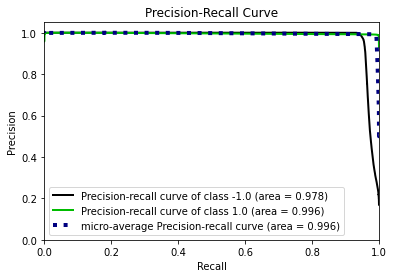

In [91]:
print_report('Test', cls_cb_s, test_pool, y_test_lo, cls_cb_s.predict(test_pool), plot_pr=True)

### under sampling

In [9]:
benign_mask = df.label_is_attack == 0
attack_mask = df.label_is_attack == 1
benign = df[benign_mask]
attack = df[attack_mask]

In [14]:
X_benign = benign.drop(['label_is_attack','label_code','label'],axis=1)
y_benign = benign[['label_is_attack','label_code','label']]

In [21]:
train_benign, test_benign = train_test_split(df[benign_mask], test_size=0.2, random_state=42)

In [22]:
y_cols = ['label', 'label_code', 'label_is_attack']
X_benign = test_benign.drop(columns=y_cols)
y_benign = test_benign[y_cols]

In [52]:
X_benign.shape

(2696942, 31)

In [30]:
X_attack = attack.drop(columns = y_cols)
y_attack = attack[y_cols]

In [33]:
X_ab = X_benign.append(X_attack)
y_ab = y_benign.append(y_attack)

In [32]:
X_ab.shape

(5445177, 31)

In [37]:
features = list(X_ab)
for i in range(len(features)):
    X_ab[features[i]] =  pd.to_numeric(X_ab[features[i]], errors='coerce')
# Creating a new normalized dataframe
X2 = X_ab[features].dropna()
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(X2)
X2 = pd.DataFrame(np_scaled)
# Principle Component Analasys Step
pca = PCA(n_components=2)
X2 = pca.fit_transform(X2)
np_scaled = min_max_scaler.fit_transform(X2)
X2 = pd.DataFrame(np_scaled)


In [44]:
LOF1 = LocalOutlierFactor(n_neighbors=20, novelty=False, contamination=0.50,n_jobs=32)
out = LOF1.fit_predict(X2)


In [40]:
l = np.array(y_ab.label_is_attack)

In [45]:
X = X_ab.copy()
X['is_attack'] = y_ab.label_is_attack
X['if_anomaly']=list(out)
X.loc[X['is_attack'] ==1, 'normal'] = -1
X.loc[X['is_attack'] ==0, 'normal'] = 1
X.head(2)

,protocol,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_mean,fwd_pkt_len_std,bwd_pkt_len_mean,flow_byts_s,...,urg_flag_cnt,down_up_ratio,init_fwd_win_byts,init_bwd_win_byts,fwd_seg_size_min,active_mean,idle_mean,is_attack,if_anomaly,normal
9276754,6,1713.0,3,0,77,0,25.666666,23.459185,0.0,44950.379451,...,0,0,258.0,17682.268468,20,0.0,0.0,0,1,1.0
8887162,6,11657.0,2,1,0,0,0.000000,0.000000,0.0,0.000000,...,1,0,61.0,254.000000,20,0.0,0.0,0,1,1.0


In [46]:
print(classification_report(X['normal'],X['if_anomaly']))

              precision    recall  f1-score   support

        -1.0       0.41      0.41      0.41   2748235
         1.0       0.40      0.41      0.40   2696942

    accuracy                           0.41   5445177
   macro avg       0.41      0.41      0.41   5445177
weighted avg       0.41      0.41      0.41   5445177

